In [2]:
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM
from keras.layers import Bidirectional
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, BatchNormalization, Dropout, GaussianNoise, GaussianDropout
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import CSVLogger, History
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import layers
from keras_multi_head import MultiHead
from sklearn.metrics import accuracy_score
import tensorflow.keras.backend as K
from sklearn.metrics import roc_auc_score

# Fig. 3 Eavaluation results in MTL4MHC2: MHC class II binding prediction by using multi-task learning.

## Used library
### Tensorflow, Keras, matplotlib, Pandas, Numpy, scikit-learn, keras_multi_head

## Could you download following files.

## Dataset 
### Our datasets are available from [here](https://bioinformatics.riken.jp/MTL4MHC2/evaluation_dataset_5cross/)

## Model(h5 file)
### Our datasets are available from [here](https://bioinformatics.riken.jp/MTL4MHC2/model/)

## other data
### embedding dictionary is available from [here](https://github.com/rikenbit/MTL4MHC2/tree/main/dict)



# Import

In [3]:
# dataset oimport

for i in range(1, 6):
    exec_1 = 'test2_x' + str(i) +  ' = np.load("{Path_to_dataset}/test2_x' + str(i) + '.npy")'
    exec(exec_1)

for i in range(1, 6):
    exec_1 = 'test2_xMHC' + str(i) + ' = np.load("{Path_to_dataset}/test2_x' + str(i) + '_mhc.npy")'
    exec(exec_1)

for i in range(1, 6):
    exec_1 = 'test2_y' + str(i) +  ' = np.load("{Path_to_dataset}/test2_y' + str(i) + '.npy")'
    exec(exec_1)    
    

In [4]:
import pickle

with open("{Path_to_pkl_file}/monovec.pkl","rb") as f:
     monovec = pickle.load(f)
    
with open("{Path_to_pkl_file}/trigram_to_idx_MHC.pkl","rb") as f:
    trigram_to_idx_MHC = pickle.load(f)

with open("{Path_to_pkl_file}/monogram_to_idx.pkl","rb") as f:
    monogram_to_idx = pickle.load(f)

with open("{Path_to_pkl_file}/trivec1_MHC.pkl","rb") as f:
    trivec1_MHC = pickle.load(f)  

# Evaluation of the Multi-task Bi-LSTM model 
# Multi-task Bi-LSTM model 1

In [44]:
def multi_bilstm(out_dim1, dropoutrate, out_dim2, out_dim3, out_dim4, loss1, loss2):
    shared_embedding = Embedding(47, 100, weights=[monovec], trainable=False)
    sharedLSTM1 = LSTM(out_dim1, dropout=dropoutrate, return_sequences=True)
    sharedLSTM2 = LSTM(out_dim2,dropout=dropoutrate)
    sharedLSTM_bw1 = LSTM(out_dim1, dropout=dropoutrate, return_sequences=True, go_backwards=True)
    sharedLSTM_bw2 = LSTM(out_dim2, dropout=dropoutrate, go_backwards=True)
    
    shared_embedding_MHC = Embedding(9419, 100, input_length=230, weights=[trivec1_MHC], trainable=False)
    sharedLSTM1_MHC = LSTM(out_dim3, dropout=dropoutrate, return_sequences=True)
    sharedLSTM2_MHC = LSTM(out_dim4,dropout=dropoutrate)
    sharedLSTM_bw1_MHC = LSTM(out_dim3, dropout=dropoutrate, return_sequences=True, go_backwards=True)
    sharedLSTM_bw2_MHC = LSTM(out_dim4, dropout=dropoutrate, go_backwards=True)
    
    
    
    text_input_c1 = keras.Input(shape=(None,))
    text_input_c2 = keras.Input(shape=(None,))
    
    encoded_input_c1 = shared_embedding(text_input_c1)
    encoded_input_c2 = shared_embedding(text_input_c2)
    
    #class I
    sharedLSTM1Instance_c1 = sharedLSTM1(encoded_input_c1)
    sharedLSTM_bw1Instance_c1 = sharedLSTM_bw1(encoded_input_c1)
    BiLSTM_c1_output_1 = layers.concatenate([sharedLSTM1Instance_c1, sharedLSTM_bw1Instance_c1], axis=-1)
    sharedLSTM2Instance_c1 =  sharedLSTM2(BiLSTM_c1_output_1)
    sharedLSTM_bw2Instance_c1 =  sharedLSTM_bw2(BiLSTM_c1_output_1)
    BiLSTM_c1_output_2 = layers.concatenate([sharedLSTM2Instance_c1, sharedLSTM_bw2Instance_c1])
    BiLSTM_c1_output_3 = Dense(64, activation='relu')(BiLSTM_c1_output_2)



    
    # class II
    sharedLSTM1Instance_c2 = sharedLSTM1(encoded_input_c2)
    sharedLSTM_bw1Instance_c2 = sharedLSTM_bw1(encoded_input_c2)
    BiLSTM_c2_output_1 = layers.concatenate([sharedLSTM1Instance_c2, sharedLSTM_bw1Instance_c2], axis=-1)
    sharedLSTM2Instance_c2 =  sharedLSTM2(BiLSTM_c2_output_1)
    sharedLSTM_bw2Instance_c2 =  sharedLSTM_bw2(BiLSTM_c2_output_1)
    BiLSTM_c2_output_2 = layers.concatenate([sharedLSTM2Instance_c2, sharedLSTM_bw2Instance_c2])
    BiLSTM_c2_output_3 = Dense(64, activation='relu')(BiLSTM_c2_output_2)


    
    text_input_c1_MHC = keras.Input(shape=(None,))
    text_input_c2_MHC = keras.Input(shape=(None,))
    
    encoded_input_c1_MHC = shared_embedding_MHC(text_input_c1_MHC)
    encoded_input_c2_MHC = shared_embedding_MHC(text_input_c2_MHC)
    
    #class I
    sharedLSTM1Instance_c1_MHC = sharedLSTM1_MHC(encoded_input_c1_MHC)
    sharedLSTM_bw1Instance_c1_MHC = sharedLSTM_bw1_MHC(encoded_input_c1_MHC)
    BiLSTM_c1_output_1_MHC = layers.concatenate([sharedLSTM1Instance_c1_MHC, sharedLSTM_bw1Instance_c1_MHC], axis=-1)
    sharedLSTM2Instance_c1_MHC =  sharedLSTM2_MHC(BiLSTM_c1_output_1_MHC)
    sharedLSTM_bw2Instance_c1_MHC =  sharedLSTM_bw2_MHC(BiLSTM_c1_output_1_MHC)
    BiLSTM_c1_output_2_MHC = layers.concatenate([sharedLSTM2Instance_c1_MHC, sharedLSTM_bw2Instance_c1_MHC])
    BiLSTM_c1_output_3_MHC = Dense(64, activation='relu')(BiLSTM_c1_output_2_MHC)


    
    # class II
    sharedLSTM1Instance_c2_MHC = sharedLSTM1_MHC(encoded_input_c2_MHC)
    sharedLSTM_bw1Instance_c2_MHC = sharedLSTM_bw1_MHC(encoded_input_c2_MHC)
    BiLSTM_c2_output_1_MHC = layers.concatenate([sharedLSTM1Instance_c2_MHC, sharedLSTM_bw1Instance_c2_MHC], axis=-1)
    sharedLSTM2Instance_c2_MHC =  sharedLSTM2_MHC(BiLSTM_c2_output_1_MHC)
    sharedLSTM_bw2Instance_c2_MHC =  sharedLSTM_bw2_MHC(BiLSTM_c2_output_1_MHC)
    BiLSTM_c2_output_2_MHC = layers.concatenate([sharedLSTM2Instance_c2_MHC, sharedLSTM_bw2Instance_c2_MHC])
    BiLSTM_c2_output_3_MHC = Dense(64, activation='relu')(BiLSTM_c2_output_2_MHC)
    
    
    conc1 = layers.concatenate([BiLSTM_c1_output_3, BiLSTM_c1_output_3_MHC], axis=-1)
    conc2 = layers.concatenate([BiLSTM_c2_output_3, BiLSTM_c2_output_3_MHC], axis=-1)
    out1 = Dense(2, activation='softmax')(conc1)
    out2 = Dense(2, activation='softmax')(conc2)
    
    
    model = Model([text_input_c1, text_input_c2, text_input_c1_MHC, text_input_c2_MHC], outputs=[out1, out2])  
    model.compile(loss=['binary_crossentropy', 'binary_crossentropy',], loss_weights=[loss1, loss2], optimizer="adam", metrics=['accuracy', 'AUC', 'Recall', 'Precision'])
    
    
    
    return model

In [45]:
model = multi_bilstm(out_dim1=128, dropoutrate=0.6, out_dim2=128, out_dim3=128, out_dim4=128, loss1=10, loss2=90)
model.load_weights('{Path_to_model_file}/task_lstm_t1_128.hdf5')

In [46]:
for i in range(1, 6):
    exec_1 = 'test2_' + str(i) +  ' = pd.DataFrame(test2_y' + str(i) + ')'
    exec(exec_1)
    exec_2 = 'test2_' + str(i) +  ' = test2_' + str(i) + '[0]'
    exec(exec_2)

In [47]:
task_lstm_t1_128_evre = pd.DataFrame()

for i in range(1, 6):
    exec_1 = 'result = model.predict([test1_x' + str(i) + ', test2_x' + str(i) + ', test1_xMHC' + str(i) + ', test2_xMHC' + str(i) + '], verbose=0)'
    exec(exec_1)
    t = pd.DataFrame(result[1])
    t = t[0]
    exec_2 = 'TP = K.sum(K.round(test2_' + str(i) + '* t))'
    exec(exec_2)
    exec_3 = 'TN = K.sum(K.cast(K.equal(K.round(test2_' + str(i) + '+ t), 0), K.floatx()))'
    exec(exec_3)
    exec_4 = 'FP = K.sum(K.cast(K.equal(K.round(t) - test2_' + str(i) + ', 1), K.floatx()))'
    exec(exec_4)
    exec_5 = 'FN = K.sum(K.cast(K.equal(test2_' + str(i) + '- K.round(t), 1), K.floatx()))'
    exec(exec_5)
    accuracy = (TP+TN)/(TP+FN+FP+TN)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    F1 = (2*precision*recall)/(precision + recall)
    from sklearn.metrics import roc_auc_score
    exec_6 = 'roc_auc = roc_auc_score(test2_' + str(i) + ', t)'
    exec(exec_6)
    evaluation = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
    evaluation = pd.DataFrame(evaluation).T
    task_lstm_t1_128_evre = pd.concat([task_lstm_t1_128_evre, evaluation], ignore_index=True)
    
    
task_lstm_t1_128_evre.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_128_evre)


,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,596.0,849.0,234.0,270.0,0.741406,0.688222,0.718072,0.702830,0.804267
1,601.0,879.0,196.0,272.0,0.759754,0.688431,0.754078,0.719761,0.830755
2,585.0,862.0,220.0,281.0,0.742813,0.675520,0.726708,0.700180,0.810132
3,630.0,816.0,227.0,275.0,0.742300,0.696133,0.735123,0.715096,0.811094
4,611.0,839.0,227.0,269.0,0.745118,0.694318,0.729117,0.711292,0.815243


# Multi-task Bi-LSTM model 3

In [49]:
model = multi_bilstm(out_dim1=256, dropoutrate=0.6, out_dim2=256, out_dim3=256, out_dim4=256, loss1=10, loss2=90)
model.load_weights('{Path_to_model_file}/task_lstm_t1_256.hdf5')

In [50]:
task_lstm_t1_256_evre = pd.DataFrame()

for i in range(1, 6):
    exec_1 = 'result = model.predict([test1_x' + str(i) + ', test2_x' + str(i) + ', test1_xMHC' + str(i) + ', test2_xMHC' + str(i) + '], verbose=0)'
    exec(exec_1)
    t = pd.DataFrame(result[1])
    t = t[0]
    exec_2 = 'TP = K.sum(K.round(test2_' + str(i) + '* t))'
    exec(exec_2)
    exec_3 = 'TN = K.sum(K.cast(K.equal(K.round(test2_' + str(i) + '+ t), 0), K.floatx()))'
    exec(exec_3)
    exec_4 = 'FP = K.sum(K.cast(K.equal(K.round(t) - test2_' + str(i) + ', 1), K.floatx()))'
    exec(exec_4)
    exec_5 = 'FN = K.sum(K.cast(K.equal(test2_' + str(i) + '- K.round(t), 1), K.floatx()))'
    exec(exec_5)
    accuracy = (TP+TN)/(TP+FN+FP+TN)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    F1 = (2*precision*recall)/(precision + recall)
    from sklearn.metrics import roc_auc_score
    exec_6 = 'roc_auc = roc_auc_score(test2_' + str(i) + ', t)'
    exec(exec_6)
    evaluation = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
    evaluation = pd.DataFrame(evaluation).T
    task_lstm_t1_256_evre = pd.concat([task_lstm_t1_256_evre, evaluation], ignore_index=True)
    
    
task_lstm_t1_256_evre.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_256_evre)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,581.0,844.0,239.0,285.0,0.731144,0.670901,0.708537,0.689205,0.803968
1,607.0,889.0,186.0,266.0,0.767967,0.695304,0.765448,0.728691,0.835158
2,579.0,881.0,201.0,287.0,0.749487,0.668591,0.742308,0.703524,0.820168
3,628.0,834.0,209.0,277.0,0.750513,0.693923,0.750299,0.721010,0.828146
4,607.0,856.0,210.0,273.0,0.751799,0.689773,0.742962,0.715380,0.820224


# Multi-task Bi-LSTM model 5

In [52]:
model = multi_bilstm(out_dim1=512, dropoutrate=0.6, out_dim2=512, out_dim3=512, out_dim4=512, loss1=10, loss2=90)
model.load_weights('{Path_to_model_file}/task_lstm_t1_512_3.hdf5')

In [53]:
task_lstm_t1_512_3_evre = pd.DataFrame()

for i in range(1, 6):
    exec_1 = 'result = model.predict([test1_x' + str(i) + ', test2_x' + str(i) + ', test1_xMHC' + str(i) + ', test2_xMHC' + str(i) + '], verbose=0)'
    exec(exec_1)
    t = pd.DataFrame(result[1])
    t = t[0]
    exec_2 = 'TP = K.sum(K.round(test2_' + str(i) + '* t))'
    exec(exec_2)
    exec_3 = 'TN = K.sum(K.cast(K.equal(K.round(test2_' + str(i) + '+ t), 0), K.floatx()))'
    exec(exec_3)
    exec_4 = 'FP = K.sum(K.cast(K.equal(K.round(t) - test2_' + str(i) + ', 1), K.floatx()))'
    exec(exec_4)
    exec_5 = 'FN = K.sum(K.cast(K.equal(test2_' + str(i) + '- K.round(t), 1), K.floatx()))'
    exec(exec_5)
    accuracy = (TP+TN)/(TP+FN+FP+TN)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    F1 = (2*precision*recall)/(precision + recall)
    from sklearn.metrics import roc_auc_score
    exec_6 = 'roc_auc = roc_auc_score(test2_' + str(i) + ', t)'
    exec(exec_6)
    evaluation = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
    evaluation = pd.DataFrame(evaluation).T
    task_lstm_t1_512_3_evre = pd.concat([task_lstm_t1_512_3_evre, evaluation], ignore_index=True)
    
    
task_lstm_t1_512_3_evre.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(task_lstm_t1_512_3_evre)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,617.0,840.0,243.0,249.0,0.747563,0.712471,0.717442,0.714948,0.812573
1,615.0,851.0,224.0,258.0,0.752567,0.704467,0.733015,0.718458,0.829381
2,596.0,846.0,236.0,270.0,0.740246,0.688222,0.716346,0.702002,0.817108
3,651.0,799.0,244.0,254.0,0.744353,0.719337,0.727374,0.723333,0.822679
4,641.0,825.0,241.0,239.0,0.753340,0.728409,0.726757,0.727582,0.824625


# Total score of the Multi-task Bi-LSTM

In [22]:
list = [task_lstm_t1_128', 'task_lstm_t1_256', 'task_lstm_t1_512']

data_c2 = pd.DataFrame()

for i in range(0, 3):
    m = [list[i]]*5
    m = pd.DataFrame(m)
    data_c2 = pd.concat([data_c2, m], ignore_index=True)

data_c2.columns = ['Data Name']    
print(data_c2)

           Data Name
0   task_lstm_t1_128
1   task_lstm_t1_128
2   task_lstm_t1_128
3   task_lstm_t1_128
4   task_lstm_t1_128
5   task_lstm_t1_256
6   task_lstm_t1_256
7   task_lstm_t1_256
8   task_lstm_t1_256
9   task_lstm_t1_256
10  task_lstm_t1_512
11  task_lstm_t1_512
12  task_lstm_t1_512
13  task_lstm_t1_512
14  task_lstm_t1_512


In [23]:
down_c2 = pd.concat([task_lstm_t1_128_evre, task_lstm_t1_256_evre, task_lstm_t1_512_3_evre], ignore_index=True)

display(down_c2)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,603.0,876.0,221.0,249.0,0.758851,0.707747,0.731796,0.719570,0.829932
1,613.0,846.0,217.0,272.0,0.748973,0.692655,0.738554,0.714869,0.810183
2,612.0,827.0,223.0,286.0,0.738706,0.681515,0.732934,0.706290,0.810005
3,585.0,858.0,211.0,294.0,0.740760,0.665529,0.734925,0.698507,0.813517
4,615.0,831.0,240.0,260.0,0.743063,0.702857,0.719298,0.710983,0.811509
5,606.0,896.0,201.0,246.0,0.770652,0.711268,0.750929,0.730561,0.832074
6,602.0,862.0,201.0,283.0,0.751540,0.680226,0.749689,0.713270,0.827880
7,603.0,840.0,210.0,295.0,0.740760,0.671492,0.741697,0.704851,0.815767
8,586.0,863.0,206.0,293.0,0.743840,0.666667,0.739899,0.701376,0.817365
9,608.0,846.0,225.0,267.0,0.747174,0.694857,0.729892,0.711944,0.815099


In [24]:
C2_total = pd.concat([data_c2, down_c2], axis = 1)
display(C2_total)

,Data Name,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,task_lstm_t1_128,603.0,876.0,221.0,249.0,0.758851,0.707747,0.731796,0.719570,0.829932
1,task_lstm_t1_128,613.0,846.0,217.0,272.0,0.748973,0.692655,0.738554,0.714869,0.810183
2,task_lstm_t1_128,612.0,827.0,223.0,286.0,0.738706,0.681515,0.732934,0.706290,0.810005
3,task_lstm_t1_128,585.0,858.0,211.0,294.0,0.740760,0.665529,0.734925,0.698507,0.813517
4,task_lstm_t1_128,615.0,831.0,240.0,260.0,0.743063,0.702857,0.719298,0.710983,0.811509
5,task_lstm_t1_256,606.0,896.0,201.0,246.0,0.770652,0.711268,0.750929,0.730561,0.832074
6,task_lstm_t1_256,602.0,862.0,201.0,283.0,0.751540,0.680226,0.749689,0.713270,0.827880
7,task_lstm_t1_256,603.0,840.0,210.0,295.0,0.740760,0.671492,0.741697,0.704851,0.815767
8,task_lstm_t1_256,586.0,863.0,206.0,293.0,0.743840,0.666667,0.739899,0.701376,0.817365
9,task_lstm_t1_256,608.0,846.0,225.0,267.0,0.747174,0.694857,0.729892,0.711944,0.815099


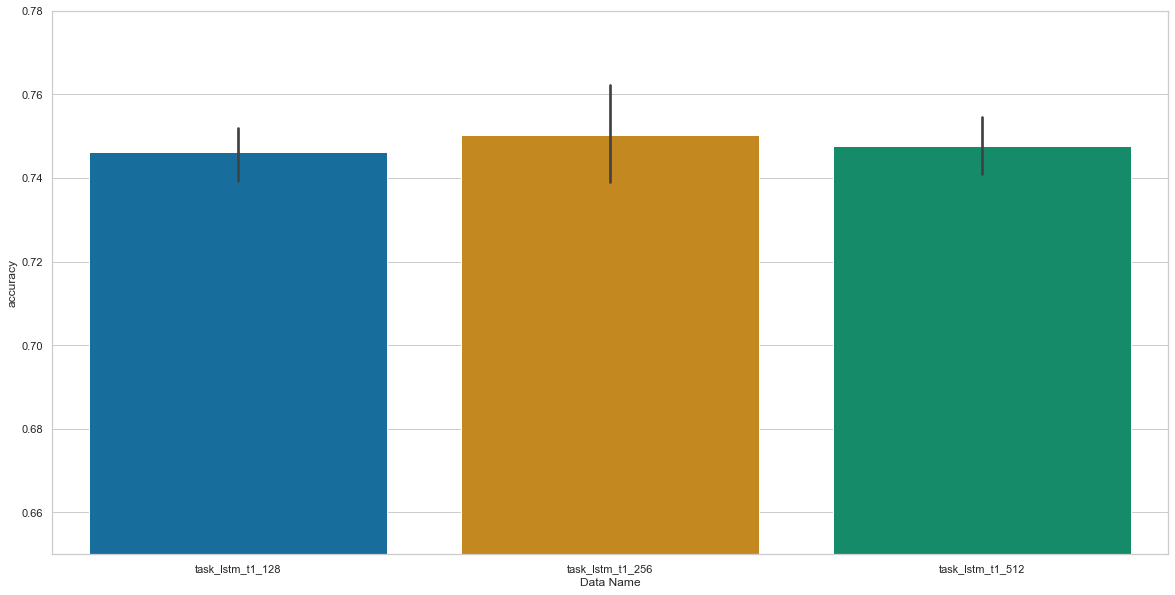

In [98]:
import seaborn as sns

plt.figure(figsize=(20, 10))
plt.ylim(0.65, 0.78)
sns.barplot(x="Data Name", y="accuracy", data=C2_total, palette="colorblind")

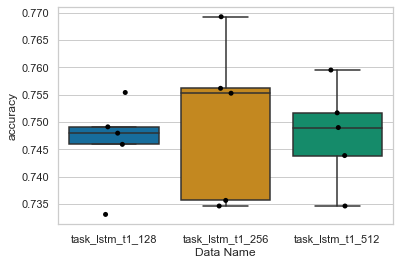

In [100]:
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set3')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='Data Name', y='accuracy', data=C2_total, showfliers=False, ax=ax, palette="colorblind")
sns.stripplot(x='Data Name', y='accuracy', data=C2_total, jitter=True, color='black', ax=ax)

plt.show()

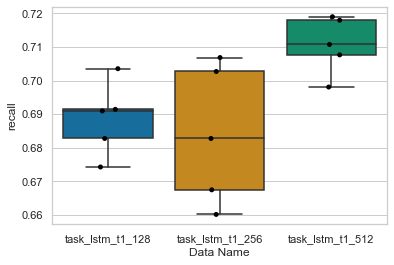

In [96]:
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set3')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='Data Name', y='recall', data=C2_total, showfliers=False, ax=ax, palette="colorblind")
sns.stripplot(x='Data Name', y='recall', data=C2_total, jitter=True, color='black', ax=ax)

plt.show()

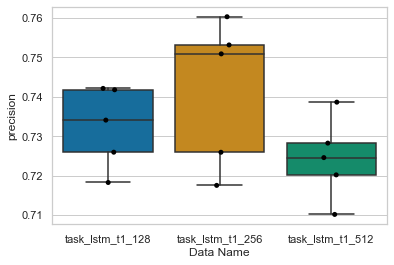

In [95]:
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set3')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='Data Name', y='precision', data=C2_total, showfliers=False, ax=ax, palette="colorblind")
sns.stripplot(x='Data Name', y='precision', data=C2_total, jitter=True, color='black', ax=ax)

plt.show()

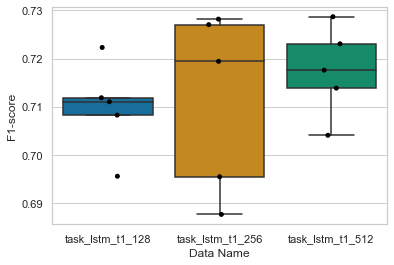

In [94]:
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set3')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='Data Name', y='F1-score', data=C2_total, showfliers=False, ax=ax, palette="colorblind")
sns.stripplot(x='Data Name', y='F1-score', data=C2_total, jitter=True, color='black', ax=ax)

plt.show()

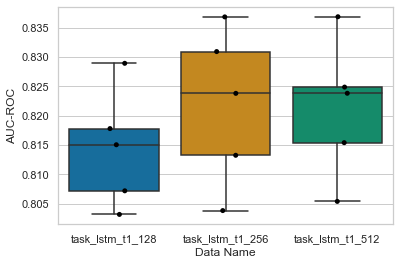

In [93]:
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set3')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='Data Name', y='AUC-ROC', data=C2_total, showfliers=False, ax=ax, palette="colorblind")
sns.stripplot(x='Data Name', y='AUC-ROC', data=C2_total, jitter=True, color='black', ax=ax)

plt.show()

# Evaluation of the Bi-LSTM model 
# Bi-LSTM model 6

In [34]:
model = keras.models.load_model('{Path_to_model_file}/modal_lstm_model6.hdf5')

In [35]:
modal_lstm_model6_evre = pd.DataFrame()

for i in range(1, 6):
    exec_1 = 'result = model.predict([test2_x' + str(i) + ', test2_xMHC' + str(i) + '], verbose=0)'
    exec(exec_1)
    t = pd.DataFrame(result)
    t = t[0]
    exec_2 = 'TP = K.sum(K.round(test2_' + str(i) + '* t))'
    exec(exec_2)
    exec_3 = 'TN = K.sum(K.cast(K.equal(K.round(test2_' + str(i) + '+ t), 0), K.floatx()))'
    exec(exec_3)
    exec_4 = 'FP = K.sum(K.cast(K.equal(K.round(t) - test2_' + str(i) + ', 1), K.floatx()))'
    exec(exec_4)
    exec_5 = 'FN = K.sum(K.cast(K.equal(test2_' + str(i) + '- K.round(t), 1), K.floatx()))'
    exec(exec_5)
    accuracy = (TP+TN)/(TP+FN+FP+TN)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    F1 = (2*precision*recall)/(precision + recall)
    from sklearn.metrics import roc_auc_score
    exec_6 = 'roc_auc = roc_auc_score(test2_' + str(i) + ', t)'
    exec(exec_6)
    evaluation = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
    evaluation = pd.DataFrame(evaluation).T
    modal_lstm_model6_evre = pd.concat([modal_lstm_model6_evre, evaluation], ignore_index=True)
    
    
modal_lstm_model6_evre.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_lstm_model6_evre)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,614.0,791.0,292.0,252.0,0.720882,0.709007,0.677704,0.693002,0.788390
1,623.0,841.0,234.0,250.0,0.751540,0.713631,0.726955,0.720231,0.816301
2,620.0,805.0,277.0,246.0,0.731520,0.715935,0.691193,0.703347,0.805329
3,643.0,780.0,263.0,262.0,0.730493,0.710497,0.709713,0.710105,0.806438
4,627.0,792.0,274.0,253.0,0.729188,0.712500,0.695893,0.704099,0.801280


# Bi-LSTM model 11

In [7]:
model = keras.models.load_model('{Path_to_model_file}/modal_lstm_model11.hdf5')

In [37]:
modal_lstm11_evre = pd.DataFrame()

for i in range(1, 6):
    exec_1 = 'result = model.predict([test2_x' + str(i) + ', test2_xMHC' + str(i) + '], verbose=0)'
    exec(exec_1)
    t = pd.DataFrame(result)
    t = t[0]
    exec_2 = 'TP = K.sum(K.round(test2_' + str(i) + '* t))'
    exec(exec_2)
    exec_3 = 'TN = K.sum(K.cast(K.equal(K.round(test2_' + str(i) + '+ t), 0), K.floatx()))'
    exec(exec_3)
    exec_4 = 'FP = K.sum(K.cast(K.equal(K.round(t) - test2_' + str(i) + ', 1), K.floatx()))'
    exec(exec_4)
    exec_5 = 'FN = K.sum(K.cast(K.equal(test2_' + str(i) + '- K.round(t), 1), K.floatx()))'
    exec(exec_5)
    accuracy = (TP+TN)/(TP+FN+FP+TN)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    F1 = (2*precision*recall)/(precision + recall)
    from sklearn.metrics import roc_auc_score
    exec_6 = 'roc_auc = roc_auc_score(test2_' + str(i) + ', t)'
    exec(exec_6)
    evaluation = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
    evaluation = pd.DataFrame(evaluation).T
    modal_lstm11_evre = pd.concat([modal_lstm11_evre, evaluation], ignore_index=True)
    
    
modal_lstm11_evre.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_lstm11_evre)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,613.0,815.0,268.0,253.0,0.732683,0.707852,0.695800,0.701774,0.792422
1,619.0,848.0,227.0,254.0,0.753080,0.709049,0.731678,0.720186,0.823313
2,607.0,828.0,254.0,259.0,0.736653,0.700924,0.704994,0.702953,0.812248
3,642.0,782.0,261.0,263.0,0.731006,0.709392,0.710963,0.710177,0.802182
4,630.0,827.0,239.0,250.0,0.748715,0.715909,0.724971,0.720412,0.811702


# Evaluation of the Multi-head Bi-LSTM model 
# Multi-head Bi-LSTM model 5

In [38]:
def multi_head_model(out_dim, dropoutrate, lay_num):
    encoder_input = Input(shape=(None,)) # encoderの入力層
    decoder_input = Input(shape=(None,)) # decoderの入力層
    
    encoder_emb = Embedding(47, 100, input_length=39, weights=[monovec], trainable=False)(encoder_input)
    decoder_emb = Embedding(9419, 100, input_length=230, weights=[trivec1_MHC], trainable=False)(decoder_input)
    
    # encoder
    encoder_output1 = MultiHead(
        layer=keras.layers.Bidirectional(keras.layers.LSTM(out_dim, dropout=dropoutrate), name='LSTM'),
        layer_num=lay_num,
        reg_index=[1, 4],
        reg_slice=(slice(None, None), slice(128, 96)),
        reg_factor=0.1,
        name='Multi-Head-Attention1',
    )(encoder_emb)
    peptide_output1 = keras.layers.Flatten(name='Flatten1')(encoder_output1)
    
    # decoder
    decoder_output1 = MultiHead(
        layer=keras.layers.Bidirectional(keras.layers.LSTM(out_dim, dropout=dropoutrate), name='LSTM'),
        layer_num=lay_num,
        reg_index=[1, 4],
        reg_slice=(slice(None, None), slice(128, 96)),
        reg_factor=0.1,
        name='Multi-Head-Attention2',
    )(decoder_emb)
    MHC_output1 = keras.layers.Flatten(name='Flatten2')(decoder_output1)
    
    conc = layers.concatenate([peptide_output1, MHC_output1], axis=-1)
    out = Dense(2, activation='softmax')(conc)
    
    model = Model([encoder_input, decoder_input], out)  # 入力と出力を設定し、Modelクラスでモデルを作成
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    return model

In [39]:
model = multi_head_model(out_dim=128, dropoutrate=0.6, lay_num=5)
model.load_weights('{Path_to_model_file}/modal_head5_weights.h5')
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 100)    4700        input_9[0][0]                    
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, None, 100)    941900      input_10[0][0]                   
____________________________________________________________________________________________

In [40]:
modal_head5_evre = pd.DataFrame()

for i in range(1, 6):
    exec_1 = 'result = model.predict([test2_x' + str(i) + ', test2_xMHC' + str(i) + '], verbose=0)'
    exec(exec_1)
    t = pd.DataFrame(result)
    t = t[0]
    exec_2 = 'TP = K.sum(K.round(test2_' + str(i) + '* t))'
    exec(exec_2)
    exec_3 = 'TN = K.sum(K.cast(K.equal(K.round(test2_' + str(i) + '+ t), 0), K.floatx()))'
    exec(exec_3)
    exec_4 = 'FP = K.sum(K.cast(K.equal(K.round(t) - test2_' + str(i) + ', 1), K.floatx()))'
    exec(exec_4)
    exec_5 = 'FN = K.sum(K.cast(K.equal(test2_' + str(i) + '- K.round(t), 1), K.floatx()))'
    exec(exec_5)
    accuracy = (TP+TN)/(TP+FN+FP+TN)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    F1 = (2*precision*recall)/(precision + recall)
    from sklearn.metrics import roc_auc_score
    exec_6 = 'roc_auc = roc_auc_score(test2_' + str(i) + ', t)'
    exec(exec_6)
    evaluation = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
    evaluation = pd.DataFrame(evaluation).T
    modal_head5_evre = pd.concat([modal_head5_evre, evaluation], ignore_index=True)
    
    
modal_head5_evre.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_head5_evre)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,509.0,890.0,193.0,357.0,0.717804,0.587760,0.725071,0.649235,0.785936
1,521.0,919.0,156.0,352.0,0.739220,0.596793,0.769572,0.672258,0.814850
2,533.0,920.0,162.0,333.0,0.745893,0.615473,0.766906,0.682896,0.802289
3,553.0,870.0,173.0,352.0,0.730493,0.611050,0.761708,0.678112,0.799990
4,527.0,896.0,170.0,353.0,0.731244,0.598864,0.756098,0.668358,0.806840


# Multi-head Bi-LSTM model 16

In [42]:
model = multi_head_model(out_dim=512, dropoutrate=0.7, lay_num=4)
model.load_weights('{Path_to_model_file}/modal_head16_weights.h5')

In [43]:
modal_head16_evre = pd.DataFrame()

for i in range(1, 6):
    exec_1 = 'result = model.predict([test2_x' + str(i) + ', test2_xMHC' + str(i) + '], verbose=0)'
    exec(exec_1)
    t = pd.DataFrame(result)
    t = t[0]
    exec_2 = 'TP = K.sum(K.round(test2_' + str(i) + '* t))'
    exec(exec_2)
    exec_3 = 'TN = K.sum(K.cast(K.equal(K.round(test2_' + str(i) + '+ t), 0), K.floatx()))'
    exec(exec_3)
    exec_4 = 'FP = K.sum(K.cast(K.equal(K.round(t) - test2_' + str(i) + ', 1), K.floatx()))'
    exec(exec_4)
    exec_5 = 'FN = K.sum(K.cast(K.equal(test2_' + str(i) + '- K.round(t), 1), K.floatx()))'
    exec(exec_5)
    accuracy = (TP+TN)/(TP+FN+FP+TN)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    F1 = (2*precision*recall)/(precision + recall)
    from sklearn.metrics import roc_auc_score
    exec_6 = 'roc_auc = roc_auc_score(test2_' + str(i) + ', t)'
    exec(exec_6)
    evaluation = [TP, TN, FP, FN, accuracy, recall, precision, F1, roc_auc]
    evaluation = pd.DataFrame(evaluation).T
    modal_head16_evre = pd.concat([modal_head16_evre, evaluation], ignore_index=True)
    
    
modal_head16_evre.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']
display(modal_head16_evre)

,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,578.0,842.0,241.0,288.0,0.728579,0.667436,0.705739,0.686053,0.790911
1,569.0,864.0,211.0,304.0,0.735626,0.651775,0.729487,0.688445,0.814853
2,580.0,867.0,215.0,286.0,0.742813,0.669746,0.729560,0.698374,0.810831
3,618.0,826.0,217.0,287.0,0.741273,0.682873,0.740120,0.710345,0.803828
4,605.0,844.0,222.0,275.0,0.744604,0.687500,0.731560,0.708846,0.807556


# Comparison of all models

In [3]:
list = ['Bi-LSRTM_model6', 'Bi-LSRTM_model11','Multi-head_model5', 'Multi-head_model16', 'Multi-tasl model1', 'Multi-tasl model3', 'Multi-tasl model5']

data_c3 = pd.DataFrame()

for i in range(0, 7):
    m = [list[i]]*5
    m = pd.DataFrame(m)
    data_c3 = pd.concat([data_c3, m], ignore_index=True)

data_c3.columns = ['Model Name']    
print(data_c3)

            Model Name
0      Bi-LSRTM_model6
1      Bi-LSRTM_model6
2      Bi-LSRTM_model6
3      Bi-LSRTM_model6
4      Bi-LSRTM_model6
5     Bi-LSRTM_model11
6     Bi-LSRTM_model11
7     Bi-LSRTM_model11
8     Bi-LSRTM_model11
9     Bi-LSRTM_model11
10   Multi-head_model5
11   Multi-head_model5
12   Multi-head_model5
13   Multi-head_model5
14   Multi-head_model5
15  Multi-head_model16
16  Multi-head_model16
17  Multi-head_model16
18  Multi-head_model16
19  Multi-head_model16
20   Multi-tasl model1
21   Multi-tasl model1
22   Multi-tasl model1
23   Multi-tasl model1
24   Multi-tasl model1
25   Multi-tasl model3
26   Multi-tasl model3
27   Multi-tasl model3
28   Multi-tasl model3
29   Multi-tasl model3
30   Multi-tasl model5
31   Multi-tasl model5
32   Multi-tasl model5
33   Multi-tasl model5
34   Multi-tasl model5


In [4]:
down_c3 = pd.concat([modal_lstm_model6_evre, modal_lstm11_evre, modal_head5_evre, modal_head16_evre, task_lstm_t1_128_evre, task_lstm_t1_256_evre, task_lstm_t1_512_3_evre], ignore_index=True)

display(down_c3)

,Unnamed: 0,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,0,633.0,803.0,242.0,271.0,0.736788,0.700221,0.723429,0.711636,0.803763
1,1,581.0,803.0,264.0,300.0,0.710472,0.659478,0.687574,0.673233,0.780644
2,2,600.0,836.0,220.0,292.0,0.737166,0.672646,0.731707,0.700935,0.811675
3,3,561.0,847.0,239.0,301.0,0.722793,0.650812,0.701250,0.675090,0.791776
4,4,587.0,876.0,219.0,264.0,0.751799,0.689777,0.728288,0.708509,0.817282
5,0,665.0,784.0,261.0,239.0,0.743458,0.735619,0.718143,0.726776,0.804605
6,1,620.0,805.0,262.0,261.0,0.731520,0.703746,0.702948,0.703347,0.795839
7,2,646.0,799.0,257.0,246.0,0.741786,0.724215,0.715393,0.719777,0.817626
8,3,605.0,832.0,254.0,257.0,0.737680,0.701856,0.704307,0.703080,0.796860
9,4,612.0,846.0,249.0,239.0,0.749229,0.719154,0.710801,0.714953,0.819847


In [5]:
C3_total = pd.concat([data_c3, down_c3], axis = 1)
display(C3_total)

,Model Name,Unnamed: 0,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,Bi-LSRTM_model6,0,633.0,803.0,242.0,271.0,0.736788,0.700221,0.723429,0.711636,0.803763
1,Bi-LSRTM_model6,1,581.0,803.0,264.0,300.0,0.710472,0.659478,0.687574,0.673233,0.780644
2,Bi-LSRTM_model6,2,600.0,836.0,220.0,292.0,0.737166,0.672646,0.731707,0.700935,0.811675
3,Bi-LSRTM_model6,3,561.0,847.0,239.0,301.0,0.722793,0.650812,0.701250,0.675090,0.791776
4,Bi-LSRTM_model6,4,587.0,876.0,219.0,264.0,0.751799,0.689777,0.728288,0.708509,0.817282
5,Bi-LSRTM_model11,0,665.0,784.0,261.0,239.0,0.743458,0.735619,0.718143,0.726776,0.804605
6,Bi-LSRTM_model11,1,620.0,805.0,262.0,261.0,0.731520,0.703746,0.702948,0.703347,0.795839
7,Bi-LSRTM_model11,2,646.0,799.0,257.0,246.0,0.741786,0.724215,0.715393,0.719777,0.817626
8,Bi-LSRTM_model11,3,605.0,832.0,254.0,257.0,0.737680,0.701856,0.704307,0.703080,0.796860
9,Bi-LSRTM_model11,4,612.0,846.0,249.0,239.0,0.749229,0.719154,0.710801,0.714953,0.819847


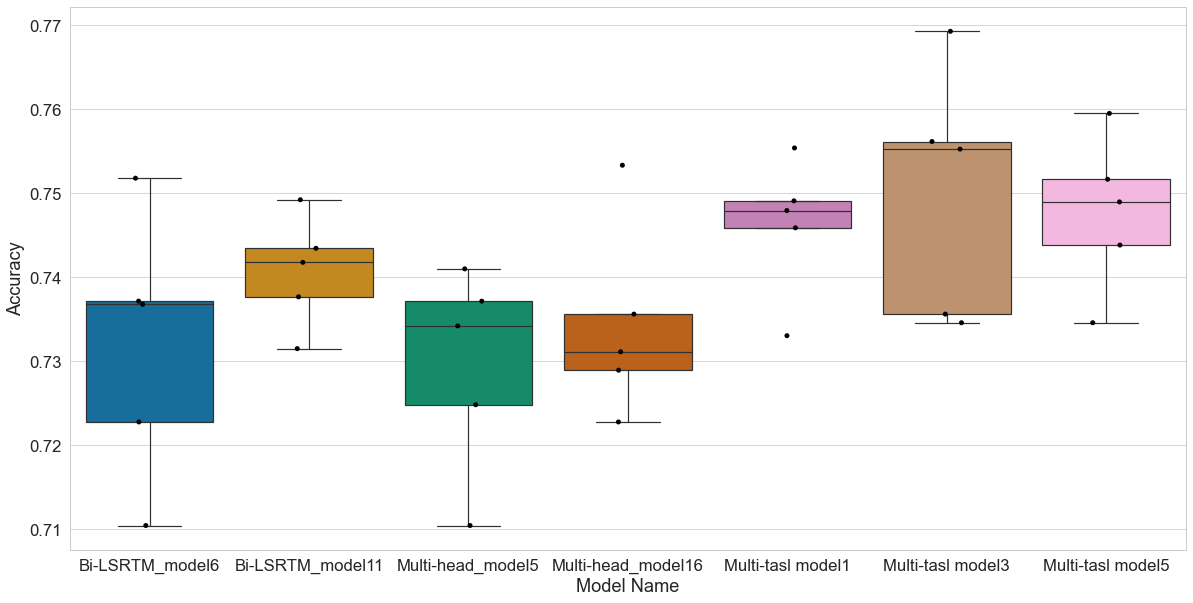

In [46]:
import seaborn as sns

sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set3')
sns.set_context("paper", font_scale=1.9)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='Model Name', y='Accuracy', data=C3_total, showfliers=False, ax=ax, palette="colorblind")
sns.stripplot(x='Model Name', y='Accuracy', data=C3_total, jitter=True, color='black', ax=ax)

plt.show()

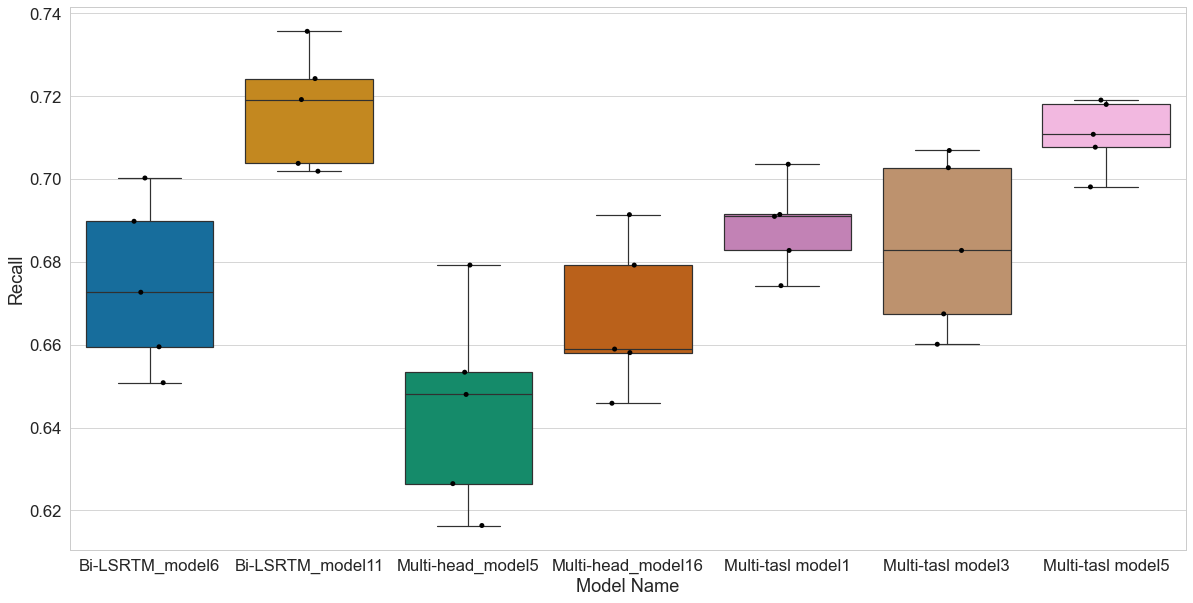

In [50]:
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set3')
sns.set_context("paper", font_scale=1.9)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='Model Name', y='Recall', data=C3_total, showfliers=False, ax=ax, palette="colorblind")
sns.stripplot(x='Model Name', y='Recall', data=C3_total, jitter=True, color='black', ax=ax)

plt.show()

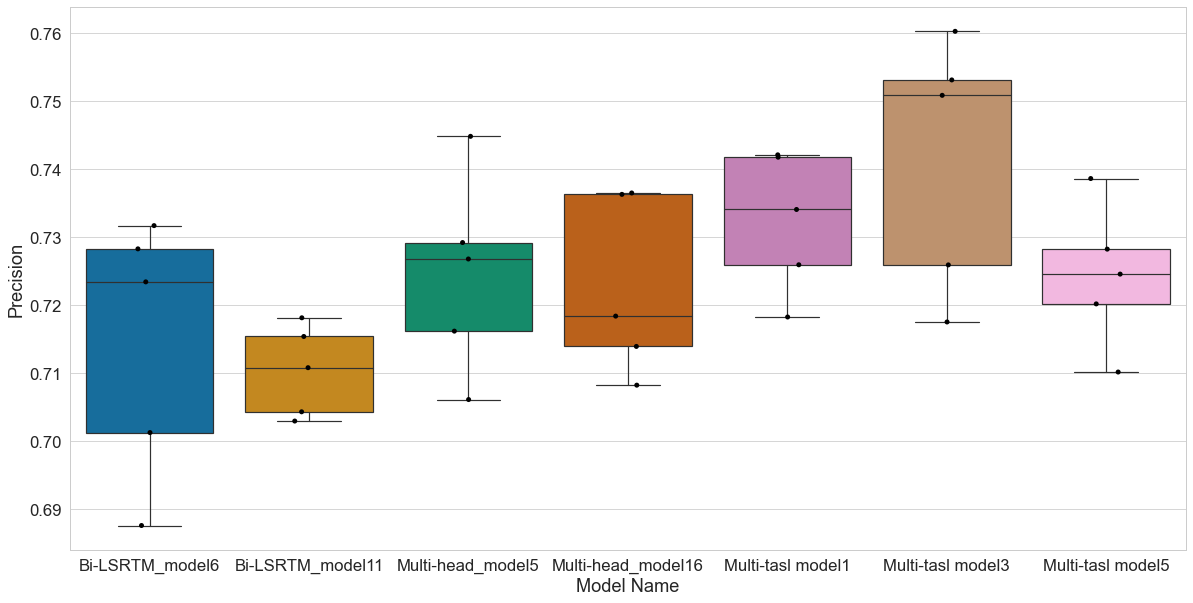

In [47]:
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set3')
sns.set_context("paper", font_scale=1.9)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='Model Name', y='Precision', data=C3_total, showfliers=False, ax=ax, palette="colorblind")
sns.stripplot(x='Model Name', y='Precision', data=C3_total, jitter=True, color='black', ax=ax)

plt.show()

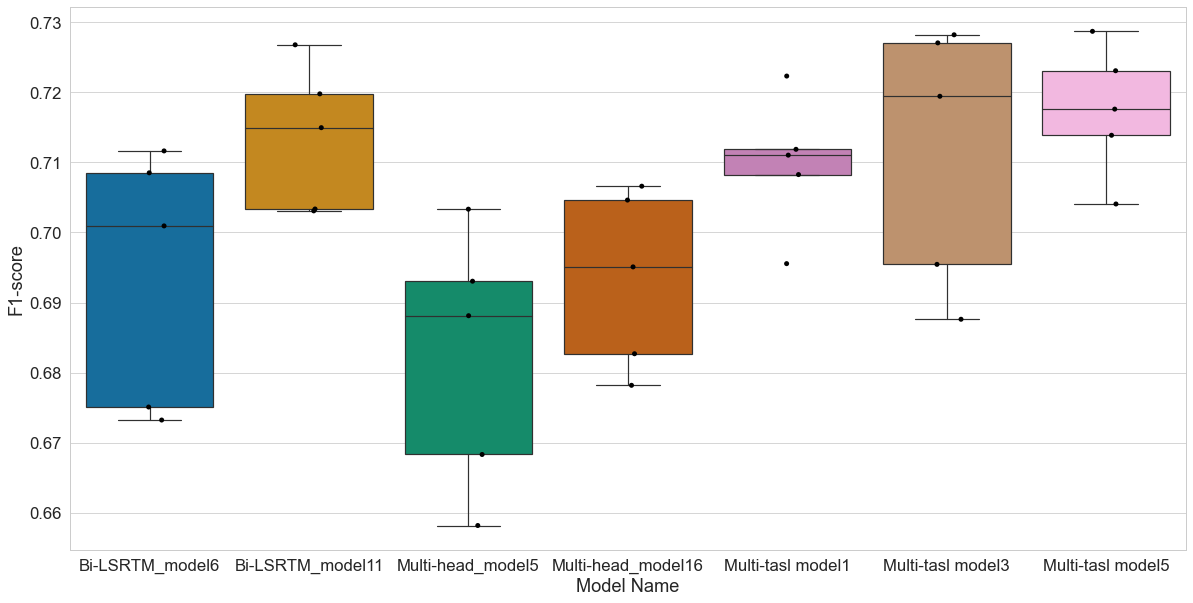

In [48]:
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set3')
sns.set_context("paper", font_scale=1.9)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='Model Name', y='F1-score', data=C3_total, showfliers=False, ax=ax, palette="colorblind")
sns.stripplot(x='Model Name', y='F1-score', data=C3_total, jitter=True, color='black', ax=ax)

plt.show()

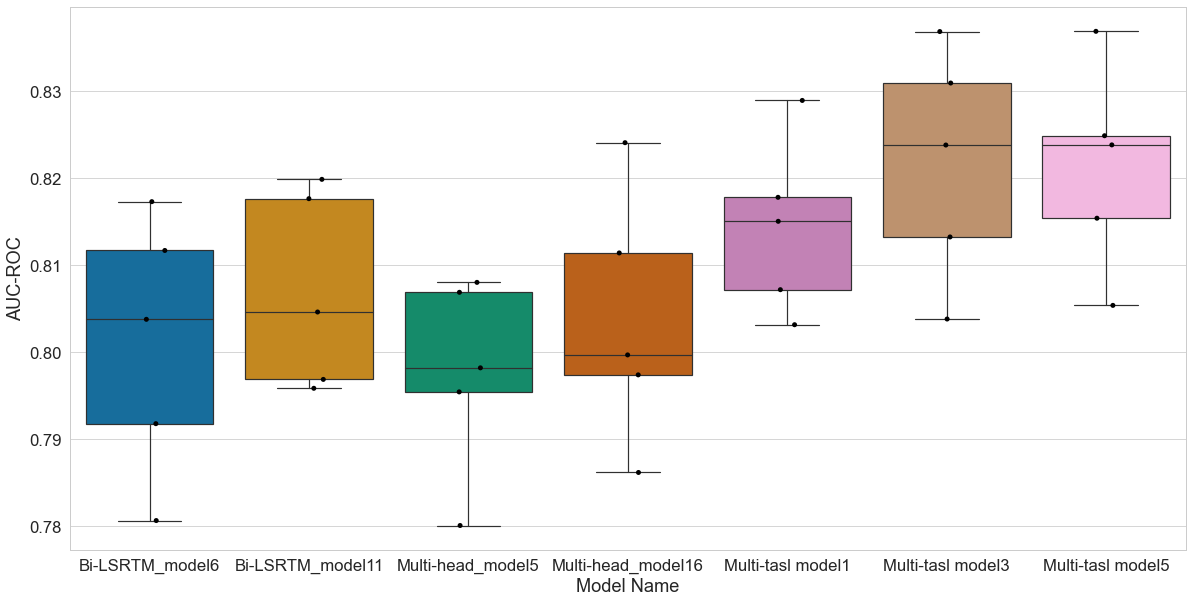

In [49]:
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set3')
sns.set_context("paper", font_scale=1.9)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='Model Name', y='AUC-ROC', data=C3_total, showfliers=False, ax=ax, palette="colorblind")
sns.stripplot(x='Model Name', y='AUC-ROC', data=C3_total, jitter=True, color='black', ax=ax)

plt.show()

In [42]:
C3_total.columns = ['Model Name', '', 'TP', 'TN', 'FP', 'FN', 'Accuracy', 'Recall', 'Precision', 'F1-score', 'AUC-ROC']
display(C3_total)

,Model Name,,TP,TN,FP,FN,Accuracy,Recall,Precision,F1-score,AUC-ROC
0,Bi-LSRTM_model6,0,633.0,803.0,242.0,271.0,0.736788,0.700221,0.723429,0.711636,0.803763
1,Bi-LSRTM_model6,1,581.0,803.0,264.0,300.0,0.710472,0.659478,0.687574,0.673233,0.780644
2,Bi-LSRTM_model6,2,600.0,836.0,220.0,292.0,0.737166,0.672646,0.731707,0.700935,0.811675
3,Bi-LSRTM_model6,3,561.0,847.0,239.0,301.0,0.722793,0.650812,0.701250,0.675090,0.791776
4,Bi-LSRTM_model6,4,587.0,876.0,219.0,264.0,0.751799,0.689777,0.728288,0.708509,0.817282
5,Bi-LSRTM_model11,0,665.0,784.0,261.0,239.0,0.743458,0.735619,0.718143,0.726776,0.804605
6,Bi-LSRTM_model11,1,620.0,805.0,262.0,261.0,0.731520,0.703746,0.702948,0.703347,0.795839
7,Bi-LSRTM_model11,2,646.0,799.0,257.0,246.0,0.741786,0.724215,0.715393,0.719777,0.817626
8,Bi-LSRTM_model11,3,605.0,832.0,254.0,257.0,0.737680,0.701856,0.704307,0.703080,0.796860
9,Bi-LSRTM_model11,4,612.0,846.0,249.0,239.0,0.749229,0.719154,0.710801,0.714953,0.819847


,Model Name,TP,TN,FP,FN,accuracy,recall,precision,F1-score,AUC-ROC
0,Bi-LSRTM_model6,633.0,803.0,242.0,271.0,0.736788,0.700221,0.723429,0.711636,0.803763
1,Bi-LSRTM_model6,581.0,803.0,264.0,300.0,0.710472,0.659478,0.687574,0.673233,0.780644
2,Bi-LSRTM_model6,600.0,836.0,220.0,292.0,0.737166,0.672646,0.731707,0.700935,0.811675
3,Bi-LSRTM_model6,561.0,847.0,239.0,301.0,0.722793,0.650812,0.701250,0.675090,0.791776
4,Bi-LSRTM_model6,587.0,876.0,219.0,264.0,0.751799,0.689777,0.728288,0.708509,0.817282
5,Bi-LSRTM_model11,665.0,784.0,261.0,239.0,0.743458,0.735619,0.718143,0.726776,0.804605
6,Bi-LSRTM_model11,620.0,805.0,262.0,261.0,0.731520,0.703746,0.702948,0.703347,0.795839
7,Bi-LSRTM_model11,646.0,799.0,257.0,246.0,0.741786,0.724215,0.715393,0.719777,0.817626
8,Bi-LSRTM_model11,605.0,832.0,254.0,257.0,0.737680,0.701856,0.704307,0.703080,0.796860
9,Bi-LSRTM_model11,612.0,846.0,249.0,239.0,0.749229,0.719154,0.710801,0.714953,0.819847


# groups comparison

# accuracy

In [8]:
from scipy import stats


bi_lstm = np.array(modal_lstm11_evre["accuracy"])
task_lstm = np.array(task_lstm_t1_128_evre["accuracy"])
multi_head = np.array(modal_head16_evre["accuracy"])

bi_lstm_var = np.var(bi_lstm, ddof=1)  # bi_lstmの不偏分散
task_lstm_var = np.var(task_lstm, ddof=1)  # task_lstmの不偏分散
multi_head_var = np.var(multi_head, ddof=1)  # multi_headの不偏分散

bi_lstm_df = len(bi_lstm) - 1  # bi_lstmの自由度
task_lstm_df = len(task_lstm) - 1  # task_lstmの自由度
multi_head_df = len(multi_head) - 1  # multi_headの自由度

# F比の値
f1 = bi_lstm_var / task_lstm_var
f2 = bi_lstm_var / multi_head_var
f3 = task_lstm_var / multi_head_var

#bi_lstm_var vs task_lstm_var
one_sided_pval1a = stats.f.cdf(f1, bi_lstm_df, task_lstm_df)  # 片側検定のp値 1
one_sided_pval2a = stats.f.sf(f1, bi_lstm_df, task_lstm_df)   # 片側検定のp値 2
two_sided_pvala = min(one_sided_pval1a, one_sided_pval2a) * 2  # 両側検定のp値

print('bi_lstm_var vs task_lstm_var')
print('F:       ', round(f1, 3))
print('p-value: ', round(two_sided_pvala, 4))


#bi_lstm_var vs multi_head_var
one_sided_pval1b = stats.f.cdf(f2, bi_lstm_df, multi_head_df)  # 片側検定のp値 1
one_sided_pval2b = stats.f.sf(f2, bi_lstm_df, multi_head_df)   # 片側検定のp値 2
two_sided_pvalb = min(one_sided_pval1b, one_sided_pval2b) * 2  # 両側検定のp値

print('bi_lstm_var vs multi_head_var')
print('F:       ', round(f2, 3))
print('p-value: ', round(two_sided_pvalb, 4))


#task_lstm_var vs multi_head_var
one_sided_pval1c = stats.f.cdf(f3, task_lstm_df, multi_head_df)  # 片側検定のp値 1
one_sided_pval2c = stats.f.sf(f3, task_lstm_df, multi_head_df)   # 片側検定のp値 2
two_sided_pvalc = min(one_sided_pval1c, one_sided_pval2c) * 2  # 両側検定のp値

print('task_lstm_var vs multi_head_var')
print('F:       ', round(f3, 3))
print('p-value: ', round(two_sided_pvalc, 4))

bi_lstm_var vs task_lstm_var
F:        0.651
p-value:  0.6875
bi_lstm_var vs multi_head_var
F:        0.327
p-value:  0.3043
task_lstm_var vs multi_head_var
F:        0.502
p-value:  0.5211


In [9]:
bi_lstm = np.array(modal_lstm11_evre["accuracy"])
task_lstm = np.array(task_lstm_t1_128_evre["accuracy"])
multi_head = np.array(modal_head16_evre["accuracy"])


b_t_t_test = stats.ttest_rel(bi_lstm, task_lstm)
b_m_t_test = stats.ttest_rel(bi_lstm, multi_head)
t_m_t_test = stats.ttest_rel(task_lstm, multi_head)

print(b_t_t_test)
print(b_m_t_test)
print(t_m_t_test)

Ttest_relResult(statistic=-3.8821028350423705, pvalue=0.01780946671211679)
Ttest_relResult(statistic=2.2760077267802674, pvalue=0.08516087124630597)
Ttest_relResult(statistic=3.8710008282391164, pvalue=0.01797818115611549)


In [10]:
bi_lstm = np.array(modal_lstm11_evre["accuracy"])
task_lstm = np.array(task_lstm_t1_256_evre["accuracy"])
multi_head = np.array(task_lstm_t1_512_3_evre["accuracy"])

bi_lstm_var = np.var(bi_lstm, ddof=1)  # bi_lstmの不偏分散
task_lstm_var = np.var(task_lstm, ddof=1)  # task_lstmの不偏分散
multi_head_var = np.var(multi_head, ddof=1)  # multi_headの不偏分散

bi_lstm_df = len(bi_lstm) - 1  # bi_lstmの自由度
task_lstm_df = len(task_lstm) - 1  # task_lstmの自由度
multi_head_df = len(multi_head) - 1  # multi_headの自由度

# F比の値
f1 = bi_lstm_var / task_lstm_var
f2 = bi_lstm_var / multi_head_var
f3 = task_lstm_var / multi_head_var

#bi_lstm_var vs task_lstm_var
one_sided_pval1a = stats.f.cdf(f1, bi_lstm_df, task_lstm_df)  # 片側検定のp値 1
one_sided_pval2a = stats.f.sf(f1, bi_lstm_df, task_lstm_df)   # 片側検定のp値 2
two_sided_pvala = min(one_sided_pval1a, one_sided_pval2a) * 2  # 両側検定のp値

print('bi_lstm_var vs task_lstm_var')
print('F:       ', round(f1, 3))
print('p-value: ', round(two_sided_pvala, 4))


#bi_lstm_var vs multi_head_var
one_sided_pval1b = stats.f.cdf(f2, bi_lstm_df, multi_head_df)  # 片側検定のp値 1
one_sided_pval2b = stats.f.sf(f2, bi_lstm_df, multi_head_df)   # 片側検定のp値 2
two_sided_pvalb = min(one_sided_pval1b, one_sided_pval2b) * 2  # 両側検定のp値

print('bi_lstm_var vs multi_head_var')
print('F:       ', round(f2, 3))
print('p-value: ', round(two_sided_pvalb, 4))


#task_lstm_var vs multi_head_var
one_sided_pval1c = stats.f.cdf(f3, task_lstm_df, multi_head_df)  # 片側検定のp値 1
one_sided_pval2c = stats.f.sf(f3, task_lstm_df, multi_head_df)   # 片側検定のp値 2
two_sided_pvalc = min(one_sided_pval1c, one_sided_pval2c) * 2  # 両側検定のp値

print('task_lstm_var vs multi_head_var')
print('F:       ', round(f3, 3))
print('p-value: ', round(two_sided_pvalc, 4))

bi_lstm_var vs task_lstm_var
F:        0.199
p-value:  0.1466
bi_lstm_var vs multi_head_var
F:        0.51
p-value:  0.5298
task_lstm_var vs multi_head_var
F:        2.565
p-value:  0.3838


In [11]:
bi_lstm = np.array(modal_lstm11_evre["accuracy"])
task_lstm256 = np.array(task_lstm_t1_256_evre["accuracy"])
task_lstm512 = np.array(task_lstm_t1_512_3_evre["accuracy"])


b_256_t_test = stats.ttest_rel(bi_lstm, task_lstm256)
b_512_t_test = stats.ttest_rel(bi_lstm, task_lstm512)


print(b_256_t_test)
print(b_512_t_test)


Ttest_relResult(statistic=-2.3349373401484548, pvalue=0.07981935023951606)
Ttest_relResult(statistic=-3.719919971003616, pvalue=0.02047595422910911)


# Precision

In [12]:
bi_lstm = np.array(modal_lstm11_evre["precision"])
task_lstm = np.array(task_lstm_t1_128_evre["precision"])
multi_head = np.array(modal_head16_evre["precision"])

bi_lstm_var = np.var(bi_lstm, ddof=1)  # bi_lstmの不偏分散
task_lstm_var = np.var(task_lstm, ddof=1)  # task_lstmの不偏分散
multi_head_var = np.var(multi_head, ddof=1)  # multi_headの不偏分散

bi_lstm_df = len(bi_lstm) - 1  # bi_lstmの自由度
task_lstm_df = len(task_lstm) - 1  # task_lstmの自由度
multi_head_df = len(multi_head) - 1  # multi_headの自由度

# F比の値
f1 = bi_lstm_var / task_lstm_var
f2 = bi_lstm_var / multi_head_var
f3 = task_lstm_var / multi_head_var

#bi_lstm_var vs task_lstm_var
one_sided_pval1a = stats.f.cdf(f1, bi_lstm_df, task_lstm_df)  # 片側検定のp値 1
one_sided_pval2a = stats.f.sf(f1, bi_lstm_df, task_lstm_df)   # 片側検定のp値 2
two_sided_pvala = min(one_sided_pval1a, one_sided_pval2a) * 2  # 両側検定のp値

print('bi_lstm_var vs task_lstm_var')
print('F:       ', round(f1, 3))
print('p-value: ', round(two_sided_pvala, 4))


#bi_lstm_var vs multi_head_var
one_sided_pval1b = stats.f.cdf(f2, bi_lstm_df, multi_head_df)  # 片側検定のp値 1
one_sided_pval2b = stats.f.sf(f2, bi_lstm_df, multi_head_df)   # 片側検定のp値 2
two_sided_pvalb = min(one_sided_pval1b, one_sided_pval2b) * 2  # 両側検定のp値

print('bi_lstm_var vs multi_head_var')
print('F:       ', round(f2, 3))
print('p-value: ', round(two_sided_pvalb, 4))


#task_lstm_var vs multi_head_var
one_sided_pval1c = stats.f.cdf(f3, task_lstm_df, multi_head_df)  # 片側検定のp値 1
one_sided_pval2c = stats.f.sf(f3, task_lstm_df, multi_head_df)   # 片側検定のp値 2
two_sided_pvalc = min(one_sided_pval1c, one_sided_pval2c) * 2  # 両側検定のp値

print('task_lstm_var vs multi_head_var')
print('F:       ', round(f3, 3))
print('p-value: ', round(two_sided_pvalc, 4))

bi_lstm_var vs task_lstm_var
F:        0.416
p-value:  0.4165
bi_lstm_var vs multi_head_var
F:        0.261
p-value:  0.2215
task_lstm_var vs multi_head_var
F:        0.627
p-value:  0.6623


In [13]:
bi_lstm = np.array(modal_lstm11_evre["precision"])
task_lstm = np.array(task_lstm_t1_256_evre["precision"])
multi_head = np.array(task_lstm_t1_512_3_evre["precision"])

bi_lstm_var = np.var(bi_lstm, ddof=1)  # bi_lstmの不偏分散
task_lstm_var = np.var(task_lstm, ddof=1)  # task_lstmの不偏分散
multi_head_var = np.var(multi_head, ddof=1)  # multi_headの不偏分散

bi_lstm_df = len(bi_lstm) - 1  # bi_lstmの自由度
task_lstm_df = len(task_lstm) - 1  # task_lstmの自由度
multi_head_df = len(multi_head) - 1  # multi_headの自由度

# F比の値
f1 = bi_lstm_var / task_lstm_var
f2 = bi_lstm_var / multi_head_var
f3 = task_lstm_var / multi_head_var

#bi_lstm_var vs task_lstm_var
one_sided_pval1a = stats.f.cdf(f1, bi_lstm_df, task_lstm_df)  # 片側検定のp値 1
one_sided_pval2a = stats.f.sf(f1, bi_lstm_df, task_lstm_df)   # 片側検定のp値 2
two_sided_pvala = min(one_sided_pval1a, one_sided_pval2a) * 2  # 両側検定のp値

print('bi_lstm_var vs task_lstm_var')
print('F:       ', round(f1, 3))
print('p-value: ', round(two_sided_pvala, 4))


#bi_lstm_var vs multi_head_var
one_sided_pval1b = stats.f.cdf(f2, bi_lstm_df, multi_head_df)  # 片側検定のp値 1
one_sided_pval2b = stats.f.sf(f2, bi_lstm_df, multi_head_df)   # 片側検定のp値 2
two_sided_pvalb = min(one_sided_pval1b, one_sided_pval2b) * 2  # 両側検定のp値

print('bi_lstm_var vs multi_head_var')
print('F:       ', round(f2, 3))
print('p-value: ', round(two_sided_pvalb, 4))


#task_lstm_var vs multi_head_var
one_sided_pval1c = stats.f.cdf(f3, task_lstm_df, multi_head_df)  # 片側検定のp値 1
one_sided_pval2c = stats.f.sf(f3, task_lstm_df, multi_head_df)   # 片側検定のp値 2
two_sided_pvalc = min(one_sided_pval1c, one_sided_pval2c) * 2  # 両側検定のp値

print('task_lstm_var vs multi_head_var')
print('F:       ', round(f3, 3))
print('p-value: ', round(two_sided_pvalc, 4))

bi_lstm_var vs task_lstm_var
F:        0.127
p-value:  0.0709
bi_lstm_var vs multi_head_var
F:        0.406
p-value:  0.4036
task_lstm_var vs multi_head_var
F:        3.184
p-value:  0.2882


In [14]:
bi_lstm = np.array(modal_lstm11_evre["precision"])
task_lstm = np.array(task_lstm_t1_128_evre["precision"])
multi_head = np.array(modal_head16_evre["precision"])


b_t_t_test = stats.ttest_rel(bi_lstm, task_lstm)
b_m_t_test = stats.ttest_rel(bi_lstm, multi_head)
t_m_t_test = stats.ttest_rel(task_lstm, multi_head)

print(b_t_t_test)
print(b_m_t_test)
print(t_m_t_test)

Ttest_relResult(statistic=-11.856918940101917, pvalue=0.00028969772907027724)
Ttest_relResult(statistic=-2.550485156931118, pvalue=0.06327285400148154)
Ttest_relResult(statistic=2.0544654592886347, pvalue=0.1091356717345481)


In [15]:
bi_lstm = np.array(modal_lstm11_evre["precision"])
task_lstm256 = np.array(task_lstm_t1_256_evre["precision"])
task_lstm512 = np.array(task_lstm_t1_512_3_evre["precision"])


b_256_t_test = stats.ttest_rel(bi_lstm, task_lstm256)
b_512_t_test = stats.ttest_rel(bi_lstm, task_lstm512)


print(b_256_t_test)
print(b_512_t_test)

Ttest_relResult(statistic=-5.260251136863132, pvalue=0.0062534277446682)
Ttest_relResult(statistic=-5.57534566360736, pvalue=0.005072509660102479)


In [ ]:
modal_head16_evre.columns = ['TP', 'TN', 'FP', 'FN', 'accuracy', 'recall', 'precision', 'F1-score', 'AUC-ROC']